<a href="https://www.kaggle.com/code/tennillehardy/customer-segmentation-rfm-analysis-k-means?scriptVersionId=165591349" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/online-retail-ii-dataset/online_retail_II.xlsx


# Introduction

Functionally, customer segmentation involves dividing a customer base into distinct groups or segments—based on shared characteristics and behaviors.

This notebook explores customer segmentation by combining two fundamental techniques: RFM (Recency, Frequency, Monetary) Analysis, and K-Means Clustering.
* RFM analysis provides a structured framework for evaluating customer behavior.
* K-Means Clustering  offers a data-driven approach to group customers into meaningful segments.

RFM Analysis is a simple yet powerful method to quantify customer behavior. It evaluates customers based on three key dimensions:
* Recency (R): How recently did a particular customer make a purchase?
* Frequency (F): How often do they make purchases?
* Monetary Value (M): How much money do they spend?

The information in the dataset will be used to compute the recency, frequency, and monetary values. Then these values will be mapped to the generally used RFM score scale of 1-5.

Following which, customer segments with similar RFM characteristics will be identified through K-Means Clustering.

# Preperation
This section focuses on loading the necessary libraries and data, and transforming the data where necessary.

## Load Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

## Load And Transform Data

In [3]:
data_path = '/kaggle/input/online-retail-ii-dataset/online_retail_II.xlsx'
#Load second sheet
df = pd.read_excel(data_path, sheet_name="Year 2010-2011")
#Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# RFM & K-Means Analysis

## Compute Recency, Frequency, and Monetary Value

In [4]:
#Add a reference date column 'snapshot_date' that is one day later than the most recent raised_at
SnapshotDate = max(df['InvoiceDate']) + pd.DateOffset(days=1)

#Create a 'Total' column that = Quantity * Price
df['Total'] = df['Quantity'] * df['Price']

#Calculate RFM value
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (SnapshotDate - x.max()).days, #number of days since organisation_id's last action
    'Invoice': 'nunique', #total number of unique invoices per organisation_id
    'Total': 'sum' #quantifies how much money/value a CustomerID spends
})

#Rename columns
rfm.rename(columns={'InvoiceDate': 'Recency', 'Invoice': 'Frequency', 'Total': 'Monetary'}, inplace=True) 
rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,326,2,0.00
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


## Map RFM values onto a 1-5 scale

In [5]:
rfm.describe()

,Recency,Frequency,Monetary
count,4372.000000,4372.000000,4372.000000
mean,92.047118,5.075480,1898.463818
std,100.765435,9.338754,8219.344627
min,1.000000,1.000000,-4287.630000
25%,17.000000,1.000000,293.362500
50%,50.000000,3.000000,648.075000
75%,143.000000,5.000000,1611.725000
max,374.000000,248.000000,279489.020000


In [6]:
#Calculate custom bin edges for Recency, Frequency, and Monetary scores
recency_bins = [rfm['Recency'].min() - 1, 17, 50, 140, 350, rfm['Recency'].max() + 2]  # Note the change here
frequency_bins = [rfm['Frequency'].min() - 1, 1, 3, 5, 250, rfm['Frequency'].max() + 1]
monetary_bins = [rfm['Monetary'].min() - 4280, 290, 650, 1600, 279400, rfm['Monetary'].max() + 1]

# Check if the bins are in increasing order
if recency_bins != sorted(recency_bins) or frequency_bins != sorted(frequency_bins):
    recency_bins.sort()
    frequency_bins.sort()
    monetary_bins.sort()

#Calculate Recency score based on custom bins
rfm['R_Score'] = pd.cut(rfm['Recency'], bins=recency_bins, labels=[1, 2, 3, 4, 5], include_lowest=True)

#Reverse the Recency scores so that higher values indicate more recent purchases
rfm['R_Score'] = 5 - rfm['R_Score'].astype(int) + 1

#Calculate Frequency and Monetary scores based on custom bins
rfm['F_Score'] = pd.cut(rfm['Frequency'], bins=frequency_bins, labels=[1, 2, 3, 4, 5], include_lowest=True).astype(int)

#Calculate Frequency and Monetary scores based on custom bins
rfm['M_Score'] = pd.cut(rfm['Monetary'], bins=monetary_bins, labels=[1, 2, 3, 4, 5], include_lowest=True).astype(int)

#Print the first few rows of the RFM DataFrame to verify the scores
print(rfm[['R_Score', 'F_Score','M_Score']].head(10))

             R_Score  F_Score  M_Score
Customer ID                           
12346.0            2        2        1
12347.0            5        4        4
12348.0            3        3        4
12349.0            4        1        4
12350.0            2        1        2
12352.0            4        4        3
12353.0            2        1        1
12354.0            2        1        3
12355.0            2        1        2
12356.0            4        2        4


## Perform K-Means Clustering

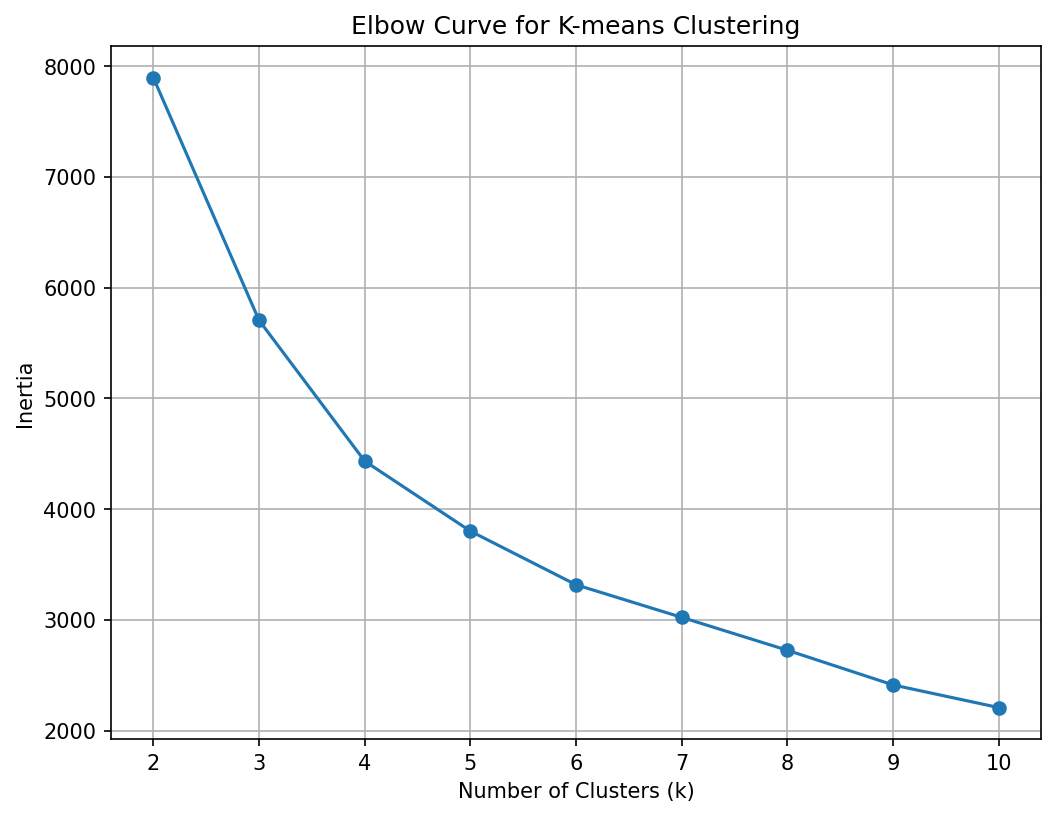

In [7]:
#Extract RFM scores for K-means clustering
X = rfm[['R_Score', 'F_Score','M_Score']]

##Find optimal number of clusters
#Calculate inertia (sum of squared distances) for different values of k
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init= 10, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6),dpi=150)
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve for K-means Clustering')
plt.grid(True)
plt.show()

In [8]:
#Curve elbows out at 4 clusters therefore divide customer base into 4 segments
#Perform K-means clustering with best K
best_kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
rfm['Cluster'] = best_kmeans.fit_predict(X)

## Interpert the clusters to identify customer segments

In [9]:
##Interpret the Clusters to Identify Customer Segments 
#Group by cluster and calculate mean values
cluster_summary = rfm.groupby('Cluster').agg({
    'R_Score': 'mean',
    'F_Score': 'mean', 
    'M_Score': 'mean'
}).reset_index()

print(cluster_summary)

   Cluster   R_Score   F_Score   M_Score
0        0  4.372973  1.738378  1.920000
1        1  2.932934  2.838323  3.219162
2        2  4.690079  3.778753  3.719930
3        3  2.293958  1.349627  1.528174


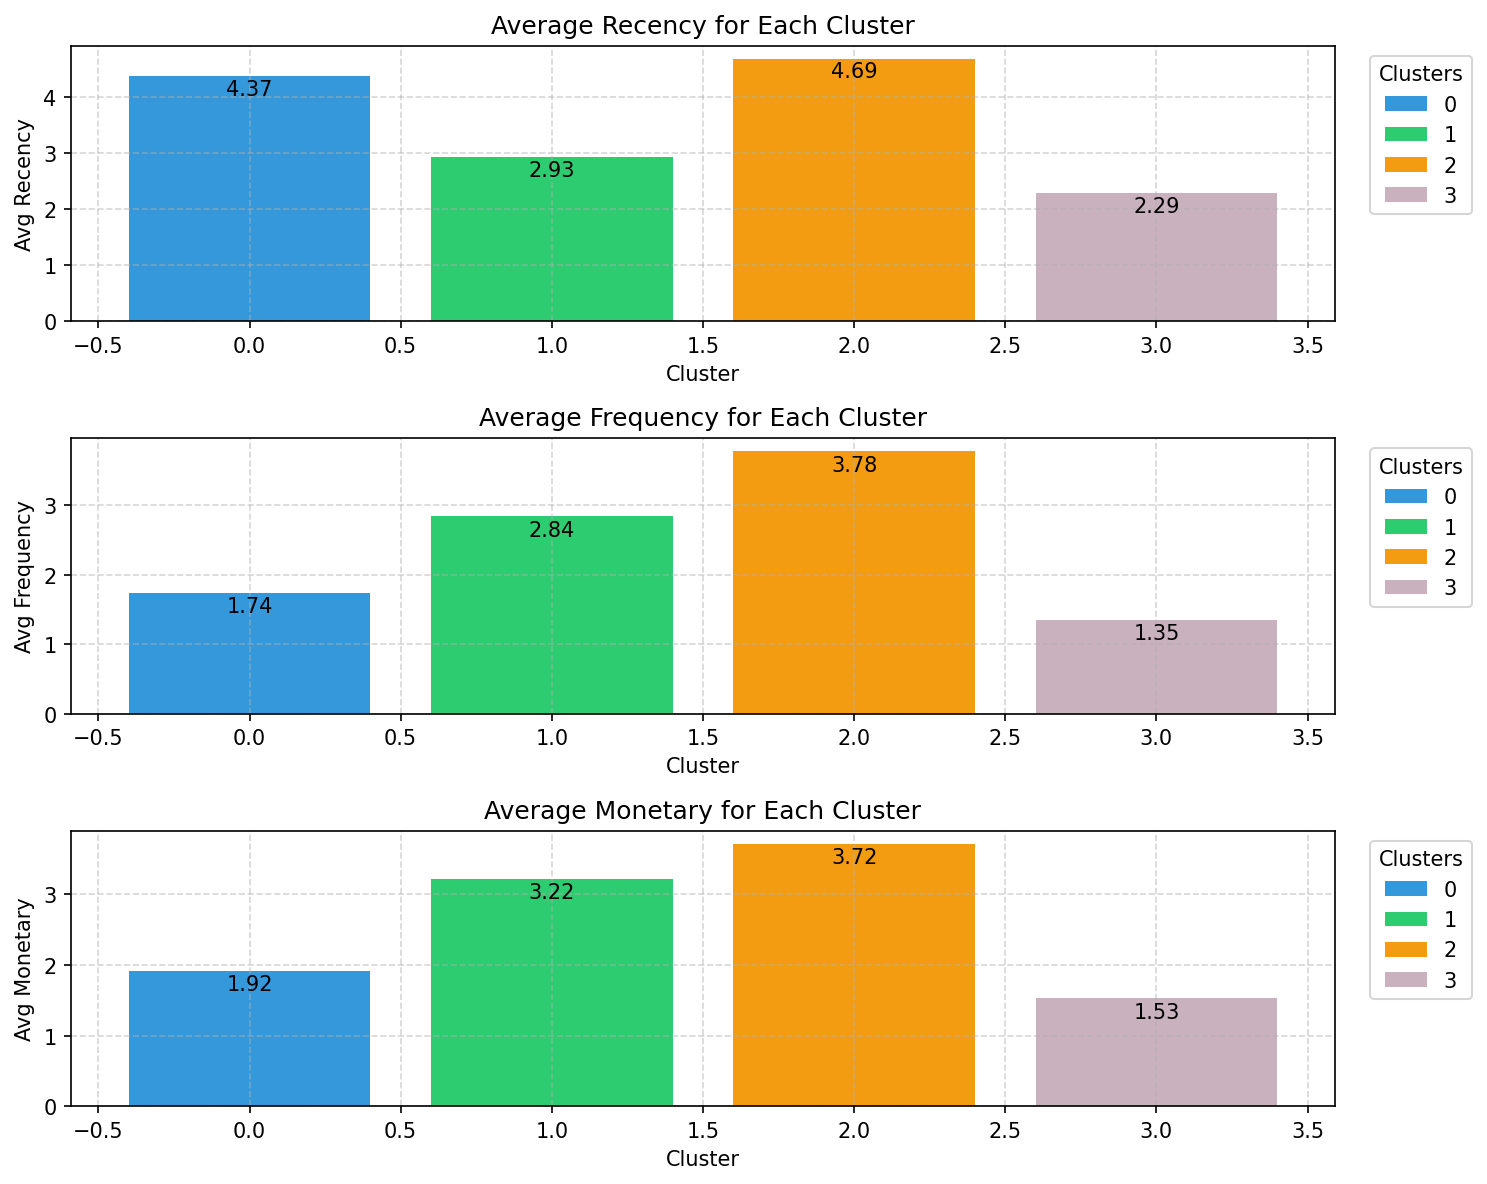

In [10]:
#Visualize the average R, F, and M scores for the clusters
colors = ['#3498db', '#2ecc71', '#f39c12', '#C9B1BD']

#Plot the average RFM scores for each cluster
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8), dpi=150)

#Plot Avg Recency
bars1 = ax1.bar(cluster_summary.index, cluster_summary['R_Score'], color=colors)
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Avg Recency')
ax1.set_title('Average Recency for Each Cluster')
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.legend(bars1, cluster_summary.index, title='Clusters', bbox_to_anchor=(1.02, 1), loc='upper left')

#Adding text annotations inside the bars
for i, v in enumerate(cluster_summary['R_Score']):
    ax1.text(i, v - 0.05, str(round(v, 2)), ha='center', va='top')

#Plot Avg Frequency
bars2 = ax2.bar(cluster_summary.index, cluster_summary['F_Score'], color=colors)
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Avg Frequency')
ax2.set_title('Average Frequency for Each Cluster')
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.legend(bars2, cluster_summary.index, title='Clusters', bbox_to_anchor=(1.02, 1), loc='upper left')

#Adding text annotations inside the bars
for i, v in enumerate(cluster_summary['F_Score']):
    ax2.text(i, v - 0.05, str(round(v, 2)), ha='center', va='top')

#Plot Avg Monetary
bars3 = ax3.bar(cluster_summary.index, cluster_summary['M_Score'], color=colors)
ax3.set_xlabel('Cluster')
ax3.set_ylabel('Avg Monetary')
ax3.set_title('Average Monetary for Each Cluster')
ax3.grid(True, linestyle='--', alpha=0.5)
ax3.legend(bars2, cluster_summary.index, title='Clusters', bbox_to_anchor=(1.02, 1), loc='upper left')

#Adding text annotations inside the bars
for i, v in enumerate(cluster_summary['M_Score']):
    ax3.text(i, v - 0.05, str(round(v, 2)), ha='center', va='top')
    
#Adjust layout to prevent title clashes
plt.subplots_adjust(top=0.85)

plt.tight_layout()
plt.show()

**Customer Segment Labels**
* champions (or power users): highest recency + highest frequency + highest monetary
* loyal customers: moderate recency + moderate frequency + moderate monetary
* recent customers: high recency + lower frequency + moderate monetary
* at-risk customers: lower recency + lower frequency

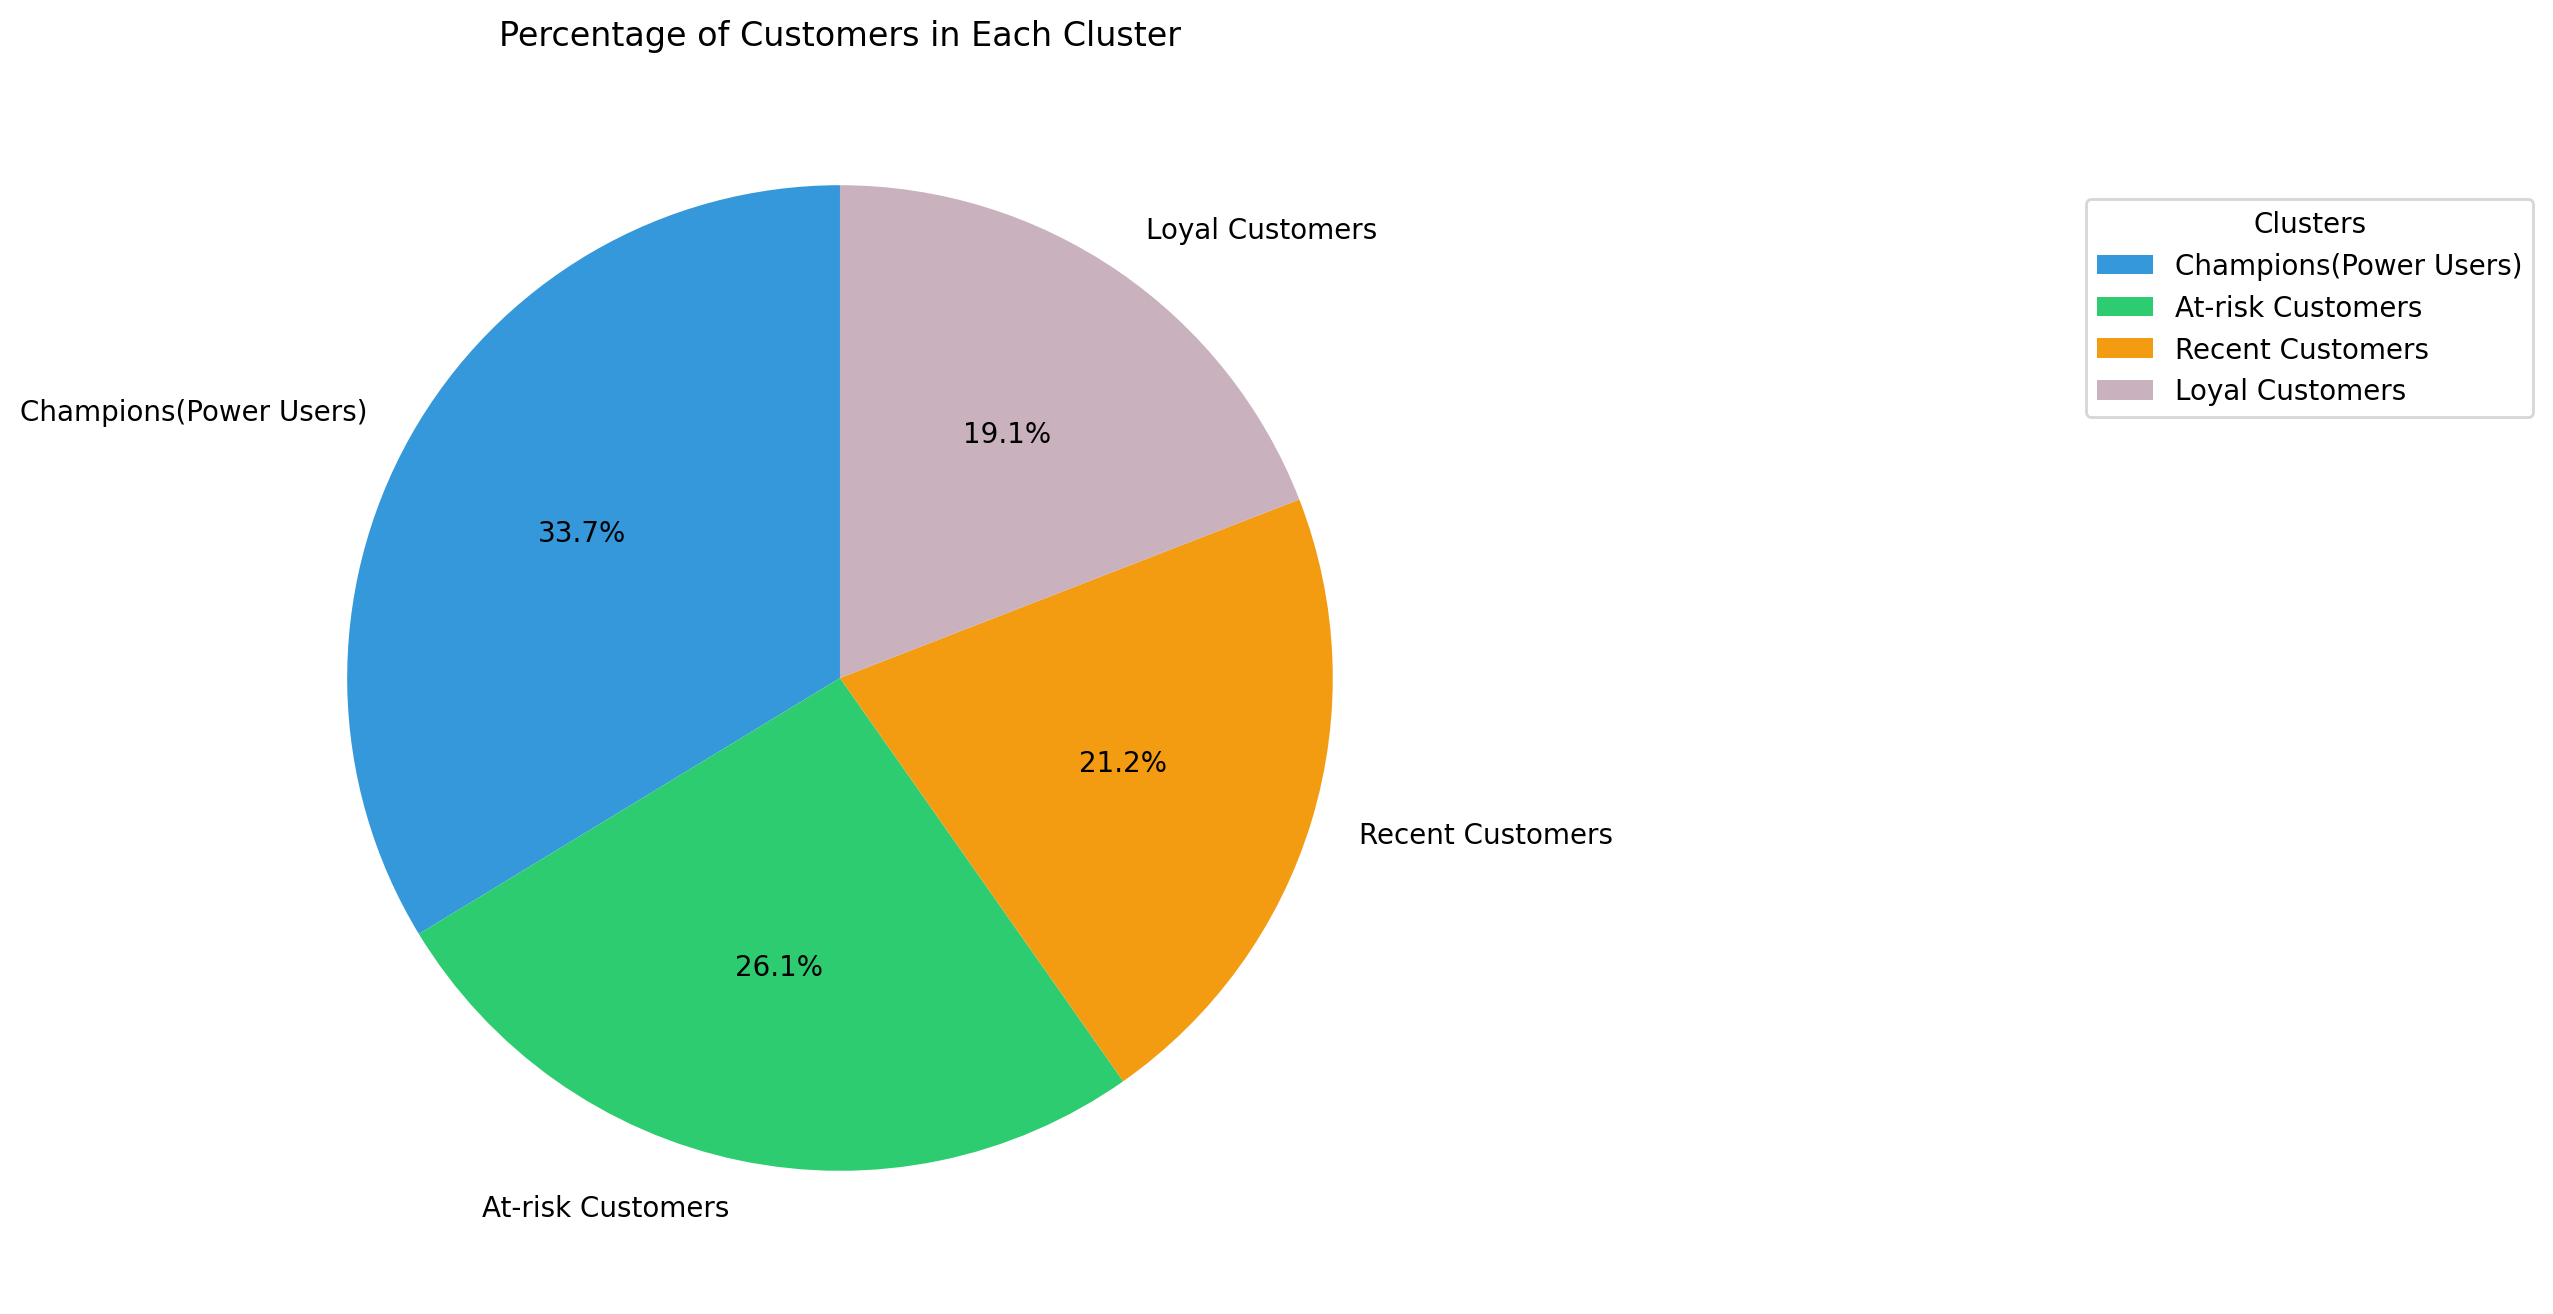

In [11]:
cluster_counts = rfm['Cluster'].value_counts()

colors = ['#3498db', '#2ecc71', '#f39c12','#C9B1BD']
# Calculate the total number of customers
total_customers = cluster_counts.sum()

# Calculate the percentage of customers in each cluster
percentage_customers = (cluster_counts / total_customers) * 100

labels = ['Champions(Power Users)','At-risk Customers','Recent Customers','Loyal Customers']

# Create a pie chart
# Create a pie chart
plt.figure(figsize=(8, 8), dpi=200)
bars, _, _ = plt.pie(percentage_customers, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Percentage of Customers in Each Cluster')
plt.legend(bars, labels, title='Clusters', bbox_to_anchor=(1.5, 0.9), loc='upper left')

plt.show()